In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import LabelEncoder
import seaborn as sns


In [2]:
df=pd.read_parquet(r'C:\Users\alqay\OneDrive\Desktop\store-sales-time-series-forecasting')

In [3]:
df.head()

,date,store_nbr,family,unit_sales,onpromotion,city,state,store_type,perishable,transactions,oil_price,day_type,Event Scale,locale_name,temperature,precipitation
0,2016-02-18,29,HOME APPLIANCES,1.000,0,Guayaquil,Guayas,E,0,965,30.77,Work Day,Non,Non,26.7,7.6
1,2016-02-18,29,HOME AND KITCHEN II,16.000,0,Guayaquil,Guayas,E,0,7720,30.77,Work Day,Non,Non,26.7,7.6
2,2016-02-18,30,PRODUCE,499.029,0,Guayaquil,Guayas,C,1,55350,30.77,Work Day,Non,Non,26.7,7.6
3,2016-02-18,31,GROCERY II,10.000,0,Babahoyo,Los Rios,B,0,3702,30.77,Work Day,Non,Non,25.7,13.4
4,2016-02-18,32,CLEANING,407.000,0,Guayaquil,Guayas,C,0,86196,30.77,Work Day,Non,Non,26.7,7.6


In [4]:
df.dropna(inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2061903 entries, 0 to 2061902
Data columns (total 16 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   store_nbr      int64         
 2   family         string        
 3   unit_sales     float64       
 4   onpromotion    int8          
 5   city           string        
 6   state          string        
 7   store_type     string        
 8   perishable     int8          
 9   transactions   int64         
 10  oil_price      float64       
 11  day_type       string        
 12  Event Scale    string        
 13  locale_name    string        
 14  temperature    float64       
 15  precipitation  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), int8(2), string(7)
memory usage: 224.2 MB


In [6]:
for col in df.select_dtypes(include='string').columns:
    df[col] = df[col].astype('object')


In [7]:
df.isnull().sum()

date             0
store_nbr        0
family           0
unit_sales       0
onpromotion      0
city             0
state            0
store_type       0
perishable       0
transactions     0
oil_price        0
day_type         0
Event Scale      0
locale_name      0
temperature      0
precipitation    0
dtype: int64

In [8]:
# IQR for all numerical columns
numerical_cols = ['unit_sales', 'transactions']
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define bounds with stricter threshold for transactions
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


# Find outliers (any column exceeding bounds)
outliers = (df[numerical_cols] < lower_bound) | (df[numerical_cols] > upper_bound)
outlier_rows = outliers.any(axis=1)

# Remove outliers
df = df[~outlier_rows]

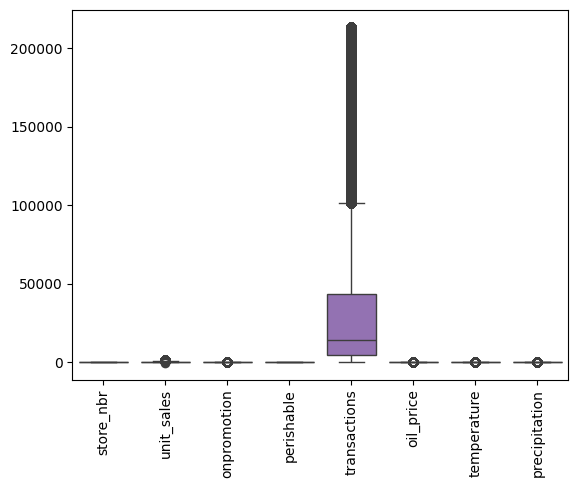

In [9]:
sns.boxplot(df)
plt.xticks(rotation=90)
plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1737938 entries, 0 to 2061902
Data columns (total 16 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   store_nbr      int64         
 2   family         object        
 3   unit_sales     float64       
 4   onpromotion    int8          
 5   city           object        
 6   state          object        
 7   store_type     object        
 8   perishable     int8          
 9   transactions   int64         
 10  oil_price      float64       
 11  day_type       object        
 12  Event Scale    object        
 13  locale_name    object        
 14  temperature    float64       
 15  precipitation  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), int8(2), object(7)
memory usage: 202.2+ MB


In [11]:
# Extract additional time-based features from 'date'
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # Weekend feature
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)


In [12]:
from sklearn.preprocessing import LabelEncoder
import pickle  # For saving

categorical_cols = ['family', 'store_type', 'city', 'state', 'day_type', 'Event Scale', 'locale_name']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# To save for later use in prediction/inference
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

In [13]:
df.head()

,date,store_nbr,family,unit_sales,onpromotion,city,state,store_type,perishable,transactions,...,temperature,precipitation,year,month,day,day_of_week,quarter,is_weekend,is_month_start,is_month_end
0,2016-02-18,29,17,1.000,0,8,6,4,0,965,...,26.7,7.6,2016,2,18,3,1,0,0,0
1,2016-02-18,29,16,16.000,0,8,6,4,0,7720,...,26.7,7.6,2016,2,18,3,1,0,0,0
2,2016-02-18,30,30,499.029,0,8,6,2,1,55350,...,26.7,7.6,2016,2,18,3,1,0,0,0
3,2016-02-18,31,13,10.000,0,1,9,1,0,3702,...,25.7,13.4,2016,2,18,3,1,0,0,0
4,2016-02-18,32,7,407.000,0,8,6,2,0,86196,...,26.7,7.6,2016,2,18,3,1,0,0,0


In [14]:
''' result = adfuller(df['unit_sales'].dropna())  # Drop missing values for ADF
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print("Data is not stationary; consider differencing or transformation.")
else:
    print("Data is stationary.")
    '''

' result = adfuller(df[\'unit_sales\'].dropna())  # Drop missing values for ADF\nprint(f\'ADF Statistic: {result[0]}\')\nprint(f\'p-value: {result[1]}\')\n\nif result[1] > 0.05:\n    print("Data is not stationary; consider differencing or transformation.")\nelse:\n    print("Data is stationary.")\n    '

In [15]:
# Correlation Matrix for numerical features
correlation_matrix = df.corr()
print("Correlation Matrix:\n", correlation_matrix)

Correlation Matrix:
                     date  store_nbr    family  unit_sales  onpromotion  \
date            1.000000   0.015496  0.048408   -0.063505     0.114966   
store_nbr       0.015496   1.000000  0.007330    0.000777     0.001049   
family          0.048408   0.007330  1.000000   -0.093926     0.042378   
unit_sales     -0.063505   0.000777 -0.093926    1.000000     0.066627   
onpromotion     0.114966   0.001049  0.042378    0.066627     1.000000   
city           -0.000047  -0.341220  0.009772    0.011151    -0.011041   
state          -0.006251  -0.225984  0.019186    0.032597    -0.018025   
store_type      0.012144  -0.397111 -0.021212   -0.019538     0.010568   
perishable     -0.111773  -0.024688  0.188471    0.397612     0.160372   
transactions   -0.008766   0.013963 -0.155100    0.838368     0.012633   
oil_price      -0.685736  -0.009539 -0.035541    0.044691    -0.083845   
day_type       -0.040841   0.000683 -0.006480   -0.006421    -0.013281   
Event Scale    -0

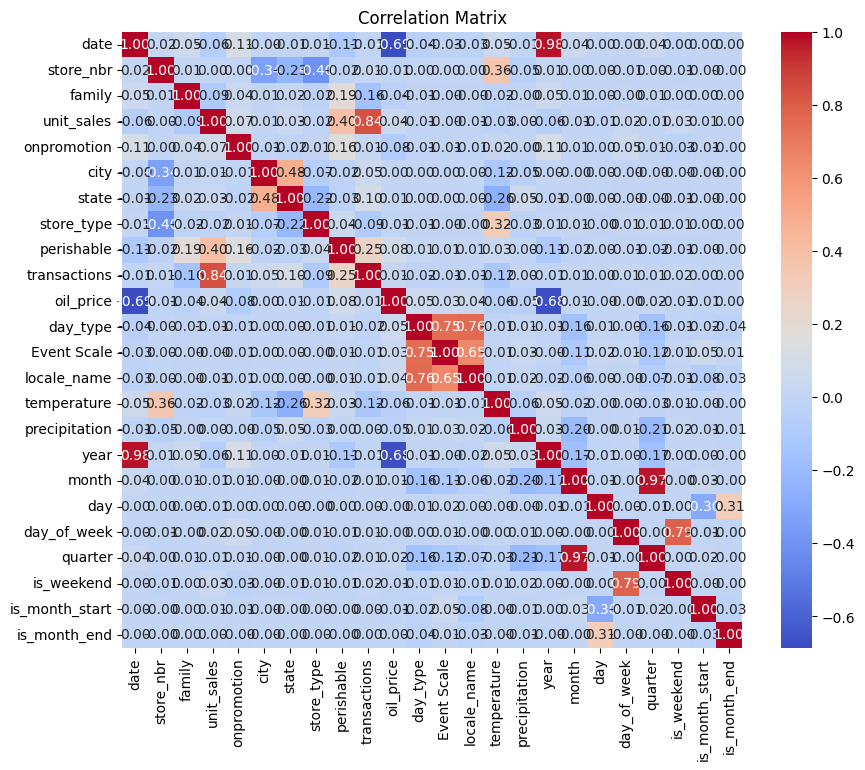

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [17]:
def create_date_features(df):
    df['day'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype('int')
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    return df

In [18]:
def create_sales_lag_features(df, lags=[1, 7, 14, 28]):
    for lag in lags:
        df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['unit_sales'].shift(lag)
    return df

In [19]:
def create_sales_rolling_features(df, windows=[7, 14, 28]):
    for window in windows:
        df[f'sales_roll_mean_{window}'] = df.groupby(['store_nbr', 'family'])['unit_sales'].shift(1).rolling(window).mean()
    return df

In [20]:
def create_transaction_features(df, lags=[1, 7, 14], windows=[7, 14]):
    for lag in lags:
        df[f'trans_lag_{lag}'] = df.groupby('store_nbr')['transactions'].shift(lag)
    for window in windows:
        df[f'trans_roll_mean_{window}'] = df.groupby('store_nbr')['transactions'].shift(1).rolling(window).mean()
    return df

In [21]:
def create_group_stats(df):
    df['mean_transactions_family'] = df.groupby('family')['transactions'].transform('mean')
    df['mean_transactions_store'] = df.groupby('store_nbr')['transactions'].transform('mean')
    df['mean_transactions_store_family'] = df.groupby(['store_nbr', 'family'])['transactions'].transform('mean')
    return df

In [22]:
df = df.sort_values(['store_nbr', 'family', 'date'])
df = create_date_features(df)
df = create_sales_lag_features(df)
df = create_sales_rolling_features(df)
df = create_transaction_features(df)
df = create_group_stats(df)


In [23]:
for clos in df.columns:
    print(clos)

date
store_nbr
family
unit_sales
onpromotion
city
state
store_type
perishable
transactions
oil_price
day_type
Event Scale
locale_name
temperature
precipitation
year
month
day
day_of_week
quarter
is_weekend
is_month_start
is_month_end
weekofyear
dayofweek
sales_lag_1
sales_lag_7
sales_lag_14
sales_lag_28
sales_roll_mean_7
sales_roll_mean_14
sales_roll_mean_28
trans_lag_1
trans_lag_7
trans_lag_14
trans_roll_mean_7
trans_roll_mean_14
mean_transactions_family
mean_transactions_store
mean_transactions_store_family


In [24]:
nulls=df.isnull().sum()
nulls[nulls>0].index

Index(['sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28',
       'sales_roll_mean_7', 'sales_roll_mean_14', 'sales_roll_mean_28',
       'trans_lag_1', 'trans_lag_7', 'trans_lag_14', 'trans_roll_mean_7',
       'trans_roll_mean_14'],
      dtype='object')

In [25]:
# Only keep rows where all features are present
data_model = df.dropna(subset=[
    'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28',
    'sales_roll_mean_7', 'sales_roll_mean_14', 'sales_roll_mean_28',
    'trans_lag_1', 'trans_lag_7', 'trans_lag_14', 'trans_roll_mean_7',
    'trans_roll_mean_14'
],inplace=True)

In [26]:
df.head()

,date,store_nbr,family,unit_sales,onpromotion,city,state,store_type,perishable,transactions,...,sales_roll_mean_14,sales_roll_mean_28,trans_lag_1,trans_lag_7,trans_lag_14,trans_roll_mean_7,trans_roll_mean_14,mean_transactions_family,mean_transactions_store,mean_transactions_store_family
1716381,2013-02-06,1,0,1.0,0,18,12,3,0,1853,...,3.142857,2.714286,6856.0,3885.0,1786.0,4270.571429,3828.500000,8357.451252,31932.825436,4386.810663
1458126,2013-02-07,1,0,1.0,0,18,12,3,0,1727,...,3.142857,2.678571,1853.0,1084.0,4167.0,3980.285714,3833.285714,8357.451252,31932.825436,4386.810663
425588,2013-02-08,1,0,2.0,0,18,12,3,0,3756,...,2.857143,2.607143,1727.0,3476.0,1521.0,4072.142857,3659.000000,8357.451252,31932.825436,4386.810663
1070834,2013-02-09,1,0,4.0,0,18,12,3,0,4416,...,2.785714,2.571429,3756.0,3544.0,1770.0,4112.142857,3818.642857,8357.451252,31932.825436,4386.810663
1716600,2013-02-10,1,0,1.0,0,18,12,3,0,374,...,3.000000,2.535714,4416.0,5631.0,1762.0,4236.714286,4007.642857,8357.451252,31932.825436,4386.810663


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1692339 entries, 1716381 to 1697384
Data columns (total 41 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   date                            datetime64[ns]
 1   store_nbr                       int64         
 2   family                          int64         
 3   unit_sales                      float64       
 4   onpromotion                     int8          
 5   city                            int64         
 6   state                           int64         
 7   store_type                      int64         
 8   perishable                      int8          
 9   transactions                    int64         
 10  oil_price                       float64       
 11  day_type                        int64         
 12  Event Scale                     int64         
 13  locale_name                     int64         
 14  temperature                     float64       
 1

In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Copy of the dataset
data = df.copy()

# ======== SELECT FEATURES & TARGET ========
features = [
    'store_nbr', 'family', 'onpromotion', 'perishable',
    'oil_price', 'temperature', 'precipitation',
    'day_of_week', 'is_month_start', 'is_month_end',
    'month', 'year', 'store_type', 'city', 'state',
    'day_type', 'Event Scale', 'locale_name',
    'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28',
    'sales_roll_mean_7', 'sales_roll_mean_14', 'sales_roll_mean_28',
]

target = 'unit_sales'

X = data[features]
y = data[target]

# ======== SPLIT THE DATA ========
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

# ======== INITIAL LINEAR REGRESSION MODEL ========
lr = LinearRegression()
lr.fit(X_train, y_train)

# ======== PREDICT & EVALUATE ========
y_pred = lr.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = r2_score(y_valid, y_pred)
mean_sales = y_valid.mean()

print("=== Linear Regression Baseline ===")
print(f"RMSE: {rmse:.2f}")
print(f"Mean unit_sales: {mean_sales:.2f}")
print(f"Relative RMSE: {(rmse / mean_sales):.2%}")
print(f"R² Score: {r2:.4f}")


=== Linear Regression Baseline ===
RMSE: 58.97
Mean unit_sales: 144.31
Relative RMSE: 40.86%
R² Score: 0.9187


In [29]:
df

,date,store_nbr,family,unit_sales,onpromotion,city,state,store_type,perishable,transactions,...,sales_roll_mean_14,sales_roll_mean_28,trans_lag_1,trans_lag_7,trans_lag_14,trans_roll_mean_7,trans_roll_mean_14,mean_transactions_family,mean_transactions_store,mean_transactions_store_family
1716381,2013-02-06,1,0,1.0,0,18,12,3,0,1853,...,3.142857,2.714286,6856.0,3885.0,1786.0,4270.571429,3828.500000,8357.451252,31932.825436,4386.810663
1458126,2013-02-07,1,0,1.0,0,18,12,3,0,1727,...,3.142857,2.678571,1853.0,1084.0,4167.0,3980.285714,3833.285714,8357.451252,31932.825436,4386.810663
425588,2013-02-08,1,0,2.0,0,18,12,3,0,3756,...,2.857143,2.607143,1727.0,3476.0,1521.0,4072.142857,3659.000000,8357.451252,31932.825436,4386.810663
1070834,2013-02-09,1,0,4.0,0,18,12,3,0,4416,...,2.785714,2.571429,3756.0,3544.0,1770.0,4112.142857,3818.642857,8357.451252,31932.825436,4386.810663
1716600,2013-02-10,1,0,1.0,0,18,12,3,0,374,...,3.000000,2.535714,4416.0,5631.0,1762.0,4236.714286,4007.642857,8357.451252,31932.825436,4386.810663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696767,2017-08-09,54,32,4.0,0,5,10,2,1,748,...,4.285714,4.178571,1504.0,2216.0,1852.0,1331.285714,1280.000000,7756.491955,16851.535641,1063.735034
149110,2017-08-10,54,32,2.0,0,5,10,2,1,670,...,4.214286,4.250000,748.0,1720.0,792.0,1121.571429,1201.142857,7756.491955,16851.535641,1063.735034
277705,2017-08-12,54,32,1.0,1,5,10,2,1,903,...,4.285714,4.250000,670.0,841.0,727.0,971.571429,1192.428571,7756.491955,16851.535641,1063.735034
535613,2017-08-13,54,32,2.0,0,5,10,2,1,1054,...,3.857143,4.214286,903.0,747.0,1400.0,980.428571,1205.000000,7756.491955,16851.535641,1063.735034


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1692339 entries, 1716381 to 1697384
Data columns (total 41 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   date                            datetime64[ns]
 1   store_nbr                       int64         
 2   family                          int64         
 3   unit_sales                      float64       
 4   onpromotion                     int8          
 5   city                            int64         
 6   state                           int64         
 7   store_type                      int64         
 8   perishable                      int8          
 9   transactions                    int64         
 10  oil_price                       float64       
 11  day_type                        int64         
 12  Event Scale                     int64         
 13  locale_name                     int64         
 14  temperature                     float64       
 1

In [31]:
#df.to_parquet(r'C:\Users\alqay\OneDrive\Desktop\store-sales-time-series-forecasting-normalized-final')